## **Fooling models with adversarial examples**

In this homework assignment, you will be crafting an adversarial attack to fool a simple machine learning model. The code for training the model is provided, so you will only be writing the code for a FGSM/PGD attack. After creating your attack, you will use it to measure the model prediction accuracy under several different attack parameters.

This assignment can be completed on Google Colab. Since there is some model training done, the free GPU can help speed up the process. To use one, you can click the down arrow in the top right of the page and select the "Change runtime type" option. From here, the T4 GPU can be selected. This is optional to do given the simplicity of the model, since the overall training will not take very long on the
 non-GPU version.

<br>

The PGD attack is formulated as:

$x_{adv}^{t+1}=\mathcal{P}(x_{adv}^{t}+\alpha*sign[∇_{x_{adv}^{t}}\mathcal{L(\theta,x_{adv}^{t},y)}])   \text{ where the attack is constrained by } ||x_{adv}-x|| \leq ɛ$.

<br>

The PGD attack is an iterative, multi-step attack. The attack is described below.

- For the initialization, $X_{adv}^0=x$ will be used.

- $\mathcal{L}(\theta,x_{adv}^t,y)$ refers to the loss of the model on the adversarial example $x_{adv}^{t}$. The attack will use the gradient of $x_{adv}^{t}$ with respect to this loss $∇_{x_{adv}^{t}}\mathcal{L(\theta,x_{adv}^{t},y)}$ to update the adversarial example.

- For each step in the attack, the $sign$ of the gradient will be used with a step of size $\alpha$ for the update. The step size $\alpha$ will vary based on the total number of steps used by the attack.

- After each step, a projection operation $\mathcal{P}$ is applied to ensure that each pixel of $x_{adv}^{t}$ is no more than $\varepsilon$ away from the original image $x$ (in practice, this can be done by clipping the image).

- The adversarial example will also be constrained to be within the bounds of a natural image [0, 1] (also through clipping).

<br>

The code below creates a simple CNN model and trains it on CIFAR-10 for 20 epochs. The code can be run without any modification.

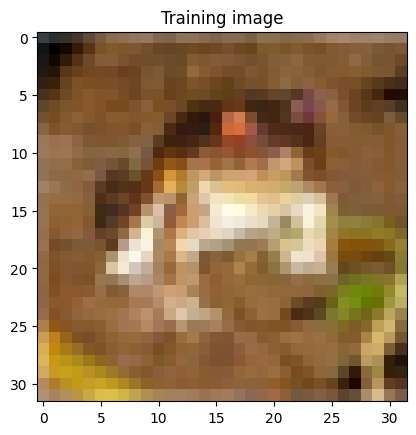

Using mps device


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(64*4*4, 256)
    self.fc2 = nn.Linear(256, num_classes)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return(x)

transform = transforms.Compose([
  transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
testset  = torchvision.datasets.CIFAR10(root='data', train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1, pin_memory=True)
testloader  = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1, pin_memory=True)

plt.imshow(trainset[0][0].permute(1,2,0))
plt.title('Training image')
plt.show()


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = CNN(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

from tqdm.notebook import tqdm

epochs = 20

for epoch in range(epochs):  # loop over the dataset multiple times

  total_correct_train, total_samples, total_loss, total_batches = 0, 0, 0, 0

  for X, Y in (pbar := tqdm(trainloader, ncols=1000)):
    X, Y = X.to(device), Y.to(device)

    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, Y)

    total_loss += loss.item()
    total_batches += 1
    total_correct_train += (pred.argmax(dim=1) == Y).sum()
    total_samples += X.shape[0]

    average_loss = total_loss/total_batches
    train_acc = total_correct_train*100/total_samples

    pbar.set_description(f"{epoch+1}/{epochs}   {average_loss=:.04e}  {train_acc=:.02f}%")

    loss.backward()
    optimizer.step()

  total_correct, total_samples, test_acc = 0, 0, 0

  for X, Y in (pbar := tqdm(testloader, ncols=1000)):
    X, Y = X.to(device), Y.to(device)
    total_samples += X.shape[0]

    with torch.no_grad(): pred = model(X)
    total_correct += (pred.argmax(dim=1) == Y).sum()

    test_acc = total_correct*100/total_samples

    pbar.set_description(f"{epoch+1}/{epochs}   {test_acc=:.02f}%")




## **Creating an adversarial attack**

Below you will find a basic template for creating the adversarial attack. Please fill out the below function where indicated.

<br>

***Details:***

We will vary the step size based on the number of steps. Recall that it is okay for any step to go beyond the boundary of $ɛ$, since it will be projected back to the $ɛ$ boundary.

- If the number of steps $= 1$, $\alpha = ɛ$
- If the number of steps $>1$ but $<4$, $\alpha = \frac{ɛ}{\text{num_steps}-1}$
- If the number of steps $\geq 4$, $\alpha = \frac{eps}{4}$

For the adversarial example generation, you will need to implement a few parts. Please look at the code for individual hints. For each step in the attack, you will need to:

- Compute the loss on the X_adv
- Compute the gradient of X_adv using this loss
- Update the X_adv using the sign of the gradient
- Clip the difference between X and X_adv to be $\leqɛ$
- Clip X_adv to being between [0, 1]

<br>

***Verification***

The code at the bottom evaluates the model on your PGD attack with $\varepsilon=\frac{8}{255}$ and 10 steps. If the implementation is correct, the accuracy of the model against the attack should be very low (around 5% or less).

In [3]:
def pgd(model=None, X=None, Y=None, eps:float=8./255, num_steps=10):
    """
    this pgd assumes the data passed to it is in the range of [0,1]
    """
    
    # Here we define the loss used. Since we are working with a classification
    # task, we will use the CrossEntropyLoss.
    loss = nn.CrossEntropyLoss()
    
    # First create a copy of the original training data. Requires_grad is set to
    # True, since the gradient of the image will need to be computed.
    X_adv = X.clone().detach().requires_grad_(True)
    
    # The model parameter gradient computation is turned off for the optimization
    # since we will not need it.
    requires_grad_list = []
    for p in model.parameters():
        requires_grad_list.append(p.requires_grad)
        p.requires_grad_(False)

    # ------------------------ [FILL IN CODE HERE] ------------------------------
    
    # The step size of the attack is chosen based on the number of steps taken.
    # ---- Fill this in ---- #
    step_size = eps
    if (num_steps > 1):
        if (num_steps < 4):
            step_size = eps/(num_steps-1)
        else:
            step_size = eps/4
    
    # Here, is the main part of the adversarial attack.
    # ---- Fill this in ---- #
    for _ in range(num_steps):
        X_adv.grad = None
        
        # Calculate the loss on the current adversarial example.
        # Hint, use the "loss" we defined before.
        # ---- Fill this in ---- #
        adv_loss = loss(model(X_adv), Y)
        
        # Compute the gradient on the adversarial image using the previous output
        # of the loss. Hint, use the .backward() operation in PyTorch.
        # ---- Fill this in ---- #
        adv_loss.backward()
        
        with torch.no_grad():
        
            # Update the adversarial example by taking a step in the direction of the
            # sign of the gradient of the image X_adv. Use the step_size you defined
            # previously.
            # ---- Fill this in ---- #
            X_adv = X_adv +  step_size * X_adv.grad.sign()
            
            # Clip the difference between X and X_adv to be within eps of each other.
            # Hint, use torch.clamp()
            # ---- Fill this in ---- #
            X_adv = torch.clamp(X_adv, X - eps, X + eps)
            
            # Clip the adversarial image to be between [0, 1].
            # ---- Fill this in ---- #
            X_adv = torch.clamp(X_adv, 0, 1)
        X_adv.requires_grad_(True)

    # ---------------------------------------------------------------------------

    # Reset the model
    for p, b in zip(model.parameters(), requires_grad_list):
        p.grad = None
        p.requires_grad_(b)

    # reset model state
    X_adv.requires_grad_(False)
    return X_adv.detach()


def evaluate_adv(model=None, testloader=None, eps=(8/255.), num_steps=10):
    '''
    This function evaluates the model using the attack parameters provided. The
    accuracy against the adversarial attack is returned along with the total
    correct and wrong prediction. No modification is necessary.
    '''
    total_samples, adv_correct, adv_acc = 0, 0, 0
    
    for X, Y in iter(testloader):
        X, Y = X.to(device), Y.to(device)
        total_samples += X.shape[0]

        if eps != 0:
            X_adv = pgd(model, X, Y, eps, num_steps)
        else:
            X_adv = X
        with torch.no_grad(): pred = model(X_adv)
        adv_correct += (pred.argmax(dim=1) == Y).sum()
        adv_acc = adv_correct*100/total_samples
    return adv_acc, adv_correct, total_samples-adv_correct


adv_acc, correct, wrong = evaluate_adv(model, testloader, eps=(8/255.), num_steps=10)

print("Correct: %i  \nWrong: %i \nTotal:  %i  \nThe adversarial accuracy is: %.2f  " % (correct.item(), wrong.item(), correct.item()+wrong.item(),  adv_acc.item()))

Correct: 92  
Wrong: 9908 
Total:  10000  
The adversarial accuracy is: 0.92  


## **Experimenting with the attack**

Now that the attack is implemented, let's experiment with it. Run the attack with some different hyperparameters and report the results. Suggestions for the values are given, but feel free to experiment with other values. Matplotlib can be used to plot the results.

- Plot the model accuracy when varying $\varepsilon$ ($\frac{0}{255} - \frac{16}{255}$) while keeping the number of steps fixed at 10.

- Plot the model accuracy when varying the number of attack steps (1 - 10) while keeping the epsilon fixed at 8/255.

- Plot images with different $\varepsilon$ ($\frac{0}{255} - \frac{30}{255}$, plotting every other value). Keep the number of steps fixed at 10.

In [3]:
acc_list = []
for x in range(17):
    acc_list.append([x, evaluate_adv(model, testloader, eps=(x/255.), num_steps=10)[0].item()])
acc_arr = np.array(acc_list)



In [ ]:
ep = acc_arr[:,0]
accuracies = acc_arr[:,1]
plt.plot(ep, accuracies)

In [ ]:
acc_list_step = []
for x in range(10):
    acc_list_step.append([x, evaluate_adv(model, testloader, eps=(8/255.), num_steps=x+1)[0].item()])
acc_step = np.array(acc_list_step)

ep_step = acc_step[:,0]
accuracies_step = acc_step[:,1]
plt.plot(ep_step, accuracies_step)

In [6]:
#img, label = trainset[0][0].to(device), trainset[0][1].to(device)
for X, Y in iter(testloader):
    X, Y = X.to(device), Y.to(device)
    total_samples += X.shape[0]



In [ ]:
for x in range(15):
    adv_ex = pgd(model, X, Y, eps=(2*x/255.))
    plt.figure()
    plt.imshow(adv_ex[0].cpu().permute(1, 2, 0))

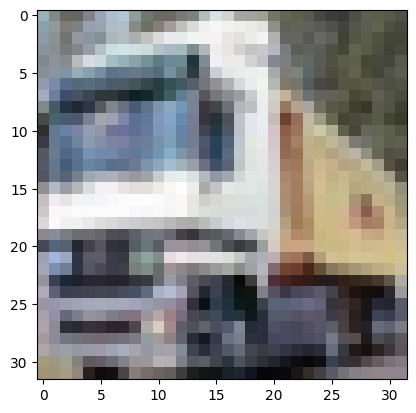

In [65]:
plt.imshow(trainset[1][0].permute(1,2,0))
plt.show()

In [9]:
from torch.utils.data import DataLoader, TensorDataset
eps=(8/255.)
num_steps=7
all_adv_images = []
all_labels = []
"""
def gen_train_test_loaders(trainloader, testloader, model, eps, num_steps):
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        adv_images = pgd(model, images, labels, eps, num_steps)
        all_adv_images.append(adv_images.cpu())
        all_labels.append(labels.cpu())
    all_adv_images = torch.cat(all_adv_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    adv_trainset = TensorDataset(all_adv_images, all_labels)
    all_adv_images = []
    all_labels = []
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)
        adv_images = pgd(model, images, labels, eps, num_steps)
        all_adv_images.append(adv_images.cpu())
        all_labels.append(labels.cpu())
    all_adv_images = torch.cat(all_adv_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    adv_testset = TensorDataset(all_adv_images, all_labels)
    adv_trainloader = DataLoader(
    adv_trainset,
    batch_size=256,
    shuffle=True,
    num_workers=1,
    multiprocessing_context='spawn'
    )
    adv_testloader = DataLoader(
    adv_testset,
    batch_size=1000,
    shuffle=False,
    num_workers=1,
    multiprocessing_context='spawn'
    )
    return (adv_trainloader, adv_testloader)
    """

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

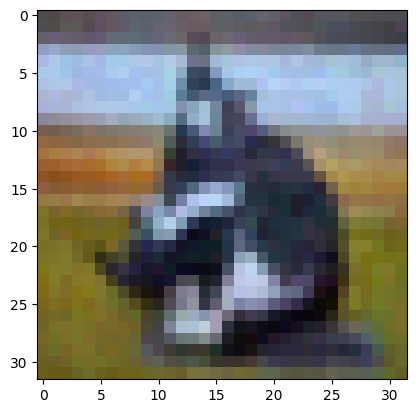

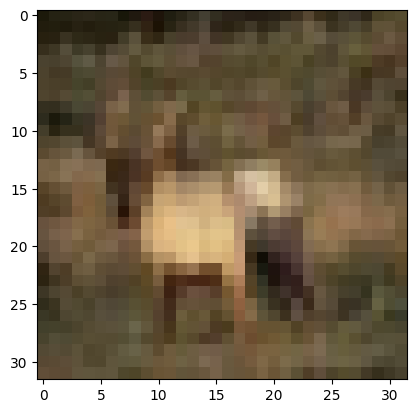

In [20]:
len(adv_trainset)
plt.figure()
plt.imshow(adv_trainset[0][0].permute(1,2,0).detach().cpu())

In [12]:
adv_trainloader = DataLoader(
    adv_trainset,
    batch_size=256,
    shuffle=True,
    num_workers=1,
    multiprocessing_context='spawn'
)

In [13]:
adv_testloader = DataLoader(
    adv_testset,
    batch_size=1000,
    shuffle=False,
    num_workers=1,
    multiprocessing_context='spawn'
)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

In [44]:
def load_cifar(train_batch_size:int=128, test_batch_size:int=1000):

    train_T = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    test_T = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.CIFAR10(root='data', train=True, transform=train_T, download=True)
    testset = torchvision.datasets.CIFAR10(root='data', train=False, transform=test_T)

    trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return trainset, testset, trainloader, testloader

In [101]:
import copy

trainset, testset, trainloader, testloader = load_cifar()

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
adv_model = ResNet18().to(device)
optimizer = torch.optim.SGD(adv_model.parameters(), lr=0.1, momentum=0.9, weight_decay=7.e-4, fused=True)

loss_fn = nn.CrossEntropyLoss()
epochs = 150
#stages 1-5, each one is 20 epochs
models = []
train_acc_list = []
adv_acc_list = []
nat_acc_list = []

for epoch in range(epochs):  # loop over the dataset multiple times

  total_correct_train, total_samples, total_loss, total_batches = 0, 0, 0, 0
  if (epoch == 50 or epoch == 100):
    optimizer.param_groups[0]['lr'] *= 0.1

  for X, Y in (pbar := tqdm(trainloader, ncols=1000)):
    X, Y = X.to(device), Y.to(device)
    X = pgd(adv_model, X, Y, eps, num_steps)
    optimizer.zero_grad()
    pred = adv_model(X)
    loss = loss_fn(pred, Y)

    total_loss += loss.item()
    total_batches += 1
    total_correct_train += (pred.argmax(dim=1) == Y).sum()
    total_samples += X.shape[0]

    average_loss = total_loss/total_batches
    train_acc = total_correct_train*100/total_samples

    pbar.set_description(f"{epoch+1}/{epochs}   {average_loss=:.04e}  {train_acc=:.02f}%")

    loss.backward()
    optimizer.step()

  total_correct, total_samples, test_acc = 0, 0, 0

  for X, Y in (pbar := tqdm(testloader, ncols=1000)):
    X, Y = X.to(device), Y.to(device)
    total_samples += X.shape[0]
    X = pgd(adv_model, X, Y, eps, 10)

    with torch.no_grad(): pred = adv_model(X)
    total_correct += (pred.argmax(dim=1) == Y).sum()

    adv_test_acc = total_correct*100/total_samples
    

    pbar.set_description(f"{epoch+1}/{epochs}   {adv_test_acc=:.02f}%")

  for X, Y in (pbar := tqdm(testloader, ncols=1000)):
    X, Y = X.to(device), Y.to(device)
    total_samples += X.shape[0]

    with torch.no_grad(): pred = adv_model(X)
    total_correct += (pred.argmax(dim=1) == Y).sum()

    nat_test_acc = total_correct*100/total_samples
    

    pbar.set_description(f"{epoch+1}/{epochs}   {nat_test_acc=:.02f}%")

  if (epoch % 30 == 0):
    models.append(copy.deepcopy(adv_model))
  train_acc_list.append(train_acc)
  nat_acc_list.append(nat_test_acc)
  adv_acc_list.append(adv_test_acc)



Using mps device


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [46]:
adv_acc, correct, wrong = evaluate_adv(adv_model, adv_testloader, eps=0, num_steps=0)
testloader = DataLoader(
    testset,
    batch_size=1000,
    shuffle=False,
    num_workers=1,
    multiprocessing_context='spawn'
)

print("Correct: %i  \nWrong: %i \nTotal:  %i  \nThe adversarial accuracy is: %.2f  " % (correct.item(), wrong.item(), correct.item()+wrong.item(),  adv_acc.item()))

Correct: 4696  
Wrong: 5304 
Total:  10000  
The adversarial accuracy is: 46.96  


In [57]:
len(models)

2

Text(0, 0.5, 'Accuracy')

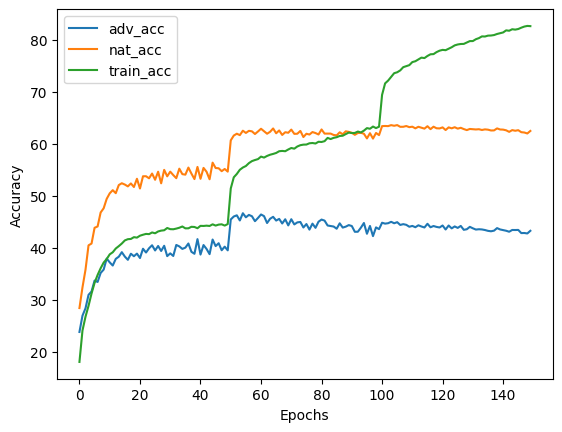

In [102]:
plt.plot([x for x in range(len(adv_acc_list))], [x.item() for x in adv_acc_list], label="adv_acc")
plt.plot([x for x in range(len(nat_acc_list))], [x.item() for x in nat_acc_list], label="nat_acc")
plt.plot([x for x in range(len(train_acc_list))], [x.item() for x in train_acc_list], label="train_acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [103]:
[x.item() for x in nat_acc_list].index(max([x.item() for x in nat_acc_list]))

105

In [104]:
len(models)

5